This notebook takes from the tutorial at https://docs.lsdb.io/en/stable/tutorials/pre_executed/des-gaia.html. I intend to manipulate it as necessary to crossmatch the data used in previous versions of des_gaia_xmatch.ipynb, and perform the data pipeline.

In [2]:
from pathlib import Path

import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt

from dask.distributed import Client
import dask.array
from dask.dataframe.utils import make_meta

from hats import read_hats
from hats.inspection import plot_pixels
from hats_import.catalog.file_readers import CsvReader
from hats_import.margin_cache.margin_cache_arguments import MarginCacheArguments
from hats_import.pipeline import ImportArguments, pipeline_with_client

import lsdb

from catalog_filtering import bandFilterLenient, contains_PM

print("Imported libraries.")

Imported libraries.


In [11]:
# Change to the directories where the data will be stored
CATALOG_DIR = Path("../../catalogs")
MARGIN_CACHE_DIR = CATALOG_DIR / 'margin_caches'

GAIA_NAME = "gaia_dr3_pm_greater_100"
GAIA_DIR = CATALOG_DIR / GAIA_NAME

DES_NAME = "des_light"
DES_DIR = CATALOG_DIR / DES_NAME 

DES_X_GAIA_NAME = "des_dr2_x_gaia_dr3"
DES_X_GAIA_DIR = CATALOG_DIR / DES_X_GAIA_NAME
DES_MARGIN_CACHE_NAME = "des_margin_cache_18_arcsec"
DES_MARGIN_CACHE_DIR = MARGIN_CACHE_DIR / DES_MARGIN_CACHE_NAME

print("Defined directories.")

Defined directories.


In [4]:
bandList = ['G','R','I','Z','Y']
class_star = None
spread_model = 0.05
magnitude_error = 0.05
check_flags = True
check_invalid_mags = True
query_string = bandFilterLenient(bandList,classStar=class_star,spreadModel=spread_model,magError=magnitude_error,flag=check_flags,invalidMags=check_invalid_mags)
des_cols = (
    [f'CLASS_STAR_{band}' for band in bandList] + 
    [f'FLAGS_{band}' for band in bandList] + 
    ['RA','DEC','COADD_OBJECT_ID'] + 
    [f'SPREAD_MODEL_{band}' for band in bandList] + 
    [f'WAVG_MAG_PSF_{band}' for band in bandList] + 
    [f'WAVG_MAGERR_PSF_{band}' for band in bandList]
)
k = 1
collinear_error_cutoff = 0.2
pm_speed_min = 2000 #units are milliseconds per year
pm_speed_max = 10**5
cone_search_rad = 50
max_neighbor_dist = 18
milliarc_degree_conversion = 1/(1000*3600)
print("Defined local vars.")

Defined local vars.


In [5]:
des_catalog = lsdb.read_hats(DES_DIR)
gaia_catalog = lsdb.read_hats(GAIA_DIR)
xmatch_catalog = lsdb.read_hats(DES_X_GAIA_DIR, columns='all')
print("Defined catalogs.")

Defined catalogs.


In [6]:
%%time
pm_filter_xmatch = xmatch_catalog.query(f'{pm_speed_max**2} >(pmra_gaia**2 + pmdec_gaia**2) > {pm_speed_min**2}')
with Client():
    df = pm_filter_xmatch.compute()

df

2025-06-02 09:59:56,255 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/distributed/worker.py", line 1269, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/distributed/utils_comm.py", line 416, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/

CPU times: user 28.3 s, sys: 861 ms, total: 29.1 s
Wall time: 1min 15s


,CLASS_STAR_G_des,CLASS_STAR_R_des,CLASS_STAR_I_des,CLASS_STAR_Z_des,CLASS_STAR_Y_des,FLAGS_G_des,FLAGS_R_des,FLAGS_I_des,FLAGS_Z_des,FLAGS_Y_des,RA_des,DEC_des,COADD_OBJECT_ID_des,SPREAD_MODEL_G_des,SPREAD_MODEL_R_des,SPREAD_MODEL_I_des,SPREAD_MODEL_Z_des,SPREAD_MODEL_Y_des,WAVG_MAG_PSF_G_des,WAVG_MAG_PSF_R_des,WAVG_MAG_PSF_I_des,WAVG_MAG_PSF_Z_des,WAVG_MAG_PSF_Y_des,WAVG_MAGERR_PSF_G_des,WAVG_MAGERR_PSF_R_des,WAVG_MAGERR_PSF_I_des,WAVG_MAGERR_PSF_Z_des,WAVG_MAGERR_PSF_Y_des,source_id_gaia,ra_gaia,dec_gaia,pmra_gaia,pmdec_gaia,_dist_arcsec
_healpix_29,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1153482605725265461,0.844888,0.845371,0.844807,0.845333,0.844827,3,3,3,3,3,1.386363,-37.369781,1043295027,-0.015229,0.040008,0.037639,0.034238,0.050002,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,2306965202564744064,1.383284,-37.367744,5633.438088,-2334.721273,11.461677
1153482609302817738,0.84542,0.845421,0.845413,0.845344,0.035287,19,19,19,19,19,1.382708,-37.367553,1043296795,0.025377,0.024557,0.017375,0.016744,0.025608,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,2306965202564744064,1.383284,-37.367744,5633.438088,-2334.721273,1.786142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3206298013938319236,0.001864,0.861837,0.986711,0.059186,0.994785,2,2,2,2,2,331.071881,-56.792344,949223282,-0.017833,0.00133,0.002163,0.036238,0.008708,23.579453,21.088121,17.886377,-99.0,13.975197,0.115939,0.012154,0.001204,-99.0,0.000657,6412596012146801152,331.076453,-56.793812,3981.976663,-2466.831815,10.448522
3206298016903817602,0.768001,0.13328,0.076799,0.102573,0.260082,1,1,1,1,1,331.073253,-56.790655,949223665,0.010093,0.018254,0.007055,-0.004826,-0.005615,-99.0,23.490891,23.837128,-99.0,-99.0,-99.0,0.13595,0.236819,-99.0,-99.0,6412596012146801152,331.076453,-56.793812,3981.976663,-2466.831815,12.998833


In [7]:
df_no_dupes = df[~df['source_id_gaia'].duplicated(keep='first')]

gaia_ids = df['source_id_gaia']

#dropping because otherwise produces error when performing .apply below
df_no_dupes = df_no_dupes.drop('source_id_gaia', axis=1)

df_no_dupes

,CLASS_STAR_G_des,CLASS_STAR_R_des,CLASS_STAR_I_des,CLASS_STAR_Z_des,CLASS_STAR_Y_des,FLAGS_G_des,FLAGS_R_des,FLAGS_I_des,FLAGS_Z_des,FLAGS_Y_des,RA_des,DEC_des,COADD_OBJECT_ID_des,SPREAD_MODEL_G_des,SPREAD_MODEL_R_des,SPREAD_MODEL_I_des,SPREAD_MODEL_Z_des,SPREAD_MODEL_Y_des,WAVG_MAG_PSF_G_des,WAVG_MAG_PSF_R_des,WAVG_MAG_PSF_I_des,WAVG_MAG_PSF_Z_des,WAVG_MAG_PSF_Y_des,WAVG_MAGERR_PSF_G_des,WAVG_MAGERR_PSF_R_des,WAVG_MAGERR_PSF_I_des,WAVG_MAGERR_PSF_Z_des,WAVG_MAGERR_PSF_Y_des,ra_gaia,dec_gaia,pmra_gaia,pmdec_gaia,_dist_arcsec
_healpix_29,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1153482605725265461,0.844888,0.845371,0.844807,0.845333,0.844827,3,3,3,3,3,1.386363,-37.369781,1043295027,-0.015229,0.040008,0.037639,0.034238,0.050002,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.383284,-37.367744,5633.438088,-2334.721273,11.461677
1257518643390044839,0.844564,0.845075,0.845251,0.843732,0.801461,2,2,2,2,2,33.079341,3.567016,1250008459,0.028251,0.024656,0.022653,0.022333,0.032334,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,33.079599,3.567385,-1762.405718,-1852.8711,1.62095
2368327529620177120,0.3251,0.177878,0.293946,0.140421,0.001102,0,0,0,0,0,53.568008,-49.893871,1398391104,-0.006986,0.000464,0.004162,0.024926,0.02906,24.553566,23.715429,23.094166,22.574404,-99.0,0.236298,0.062562,0.070822,0.11552,-99.0,53.567196,-49.890084,2360.592206,483.127504,13.763072
2390050329526096144,0.125803,0.120065,0.028601,0.028627,0.028627,3,3,3,3,3,62.610625,-53.614224,1464092812,0.010486,0.038736,0.037149,0.040352,0.041889,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,62.611,-53.612997,-825.17937,-2415.577565,4.490123
2405297220004419732,0.194207,0.84529,0.84489,0.845284,0.029913,3,3,3,3,3,77.964238,-45.04643,1540617639,0.008839,0.006246,0.002662,0.001698,0.005954,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,77.959937,-45.043813,6491.223339,-5708.61415,14.437522
2423978658324676571,0.845425,0.845425,0.845406,0.845371,0.84513,22,22,18,18,22,50.000054,-43.066641,1445898840,-0.000132,-0.000009,0.000011,0.000009,0.000002,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,50.000344,-43.066553,3035.017316,726.964482,0.825611
2450054482295873745,0.844839,0.845014,0.845117,0.845267,0.844982,2,2,2,2,6,5.037242,-64.869108,1054999950,0.000474,0.000276,-0.000397,0.000404,1.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,5.03561,-64.869617,1706.746855,1164.959443,3.096527
2468500457058623057,0.84536,0.029197,0.845341,0.842975,0.047746,2,3,2,2,2,32.623122,-50.820946,1243465193,0.00557,0.00185,0.001703,0.001036,0.004741,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,32.622946,-50.820906,2125.416147,637.975043,0.425698
2468500457058623057,0.84536,0.029197,0.845341,0.842975,0.047746,2,3,2,2,2,32.623122,-50.820946,1243465193,0.00557,0.00185,0.001703,0.001036,0.004741,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,32.624069,-50.820823,2168.886011,710.847727,2.199757


In [7]:
df_no_dupes.to_csv('gaia_high_pm_stars.csv')

In [8]:
def distance_to_line(line_vector, PQ):
    #Add zero for proper cross product in distance_to_line
    PQ_3D = np.append(PQ, 0)
    line_vector_3D = np.append(line_vector, 0)
    return np.linalg.norm(np.abs(np.cross(PQ_3D, line_vector_3D)) / np.linalg.norm(line_vector_3D))

def within_collinear_error(line_vector, PQ, error):
    return (distance_to_line(line_vector, PQ) <= error)


# Consider making the RA and DEC columns arguments into this func

def kth_star_min_distance(group, k, cols_to_keep):
    origin_ra, origin_dec = group['RA_1'], group['DEC_1']
    ra2, dec2 = group[["RA_2", "DEC_2"]].to_numpy().T
    
    x_vals = (ra2 - origin_ra) * np.cos(np.radians(origin_dec)) * 3600
    y_vals = (dec2 - origin_dec) * 3600
    delta_coords = np.vstack((x_vals, y_vals)).T 

    kth_distances = [None] * len(delta_coords)

    for i in range(len(delta_coords)):
        proj_vector = delta_coords[i]
        distances = []

        if np.all(proj_vector == 0): continue #ensures vector points to a point that is not the origin

        for j in range(len(delta_coords)):
            if np.all(delta_coords[j] == 0) or (j == i): continue
            
            distances.append(distance_to_line(proj_vector, delta_coords[j]))

        kth_distances[i] = sorted(distances)[k]
    
    group['kth_min_proj_error'] = kth_distances

    return group[cols_to_keep + ['kth_min_proj_error']]



def algo_found_pm(row, des_cols, cone_search_rad, query_string, max_neighbor_dist, k, collinear_error_cutoff):    
    # Filter DES around PM of interest:
    filtered_catalog = (
        lsdb.read_hats(DES_DIR, columns=des_cols, margin_cache=DES_MARGIN_CACHE_DIR)
        .cone_search(ra=row['ra_gaia'], dec=row['dec_gaia'], radius_arcsec=cone_search_rad)
        .query(query_string)
    )
    
    xmatch = filtered_catalog.crossmatch(filtered_catalog,
                n_neighbors=100, 
                radius_arcsec=max_neighbor_dist, 
                suffixes=['_1', '_2'])
    xmatch_ddf = xmatch._ddf

    neighbors = xmatch_ddf.groupby('_healpix_29')['_dist_arcsec'].count()
    neighbors -= 1 #Double counting adjustment
    neighbors.name = 'neighbors'
    xmatch_ddf = xmatch_ddf.join(neighbors, on='_healpix_29')
    xmatch_large_groups = xmatch_ddf.query('neighbors >= 3')
    columns_to_keep = (
        [col for col in xmatch_large_groups.columns if col.endswith('_2')]
    )

    meta = make_meta(xmatch_large_groups[columns_to_keep])
    meta['kth_min_proj_error'] = 0.0
    star_groups = xmatch_large_groups.groupby('_healpix_29').apply(kth_star_min_distance, meta=meta, k=k-1, cols_to_keep = columns_to_keep)  
    df = star_groups.compute().reset_index(drop=True, level = 0)

    if bool(not (df.query(f'kth_min_proj_error < {collinear_error_cutoff}').empty)):
        return df['kth_min_proj_error'].min()
    else:
        return np.nan

In [12]:
%%time

df_no_dupes['algo_found'] = df_no_dupes.apply(func=algo_found_pm, axis=1, des_cols=des_cols, cone_search_rad=cone_search_rad, query_string=query_string, max_neighbor_dist=max_neighbor_dist, k=k, collinear_error_cutoff=collinear_error_cutoff)
# df_no_dupes['source_id_gaia'] = gaia_ids
df_no_dupes

CPU times: user 39.3 s, sys: 1.91 s, total: 41.2 s
Wall time: 1min


,CLASS_STAR_G_des,CLASS_STAR_R_des,CLASS_STAR_I_des,CLASS_STAR_Z_des,CLASS_STAR_Y_des,FLAGS_G_des,FLAGS_R_des,FLAGS_I_des,FLAGS_Z_des,FLAGS_Y_des,RA_des,DEC_des,COADD_OBJECT_ID_des,SPREAD_MODEL_G_des,SPREAD_MODEL_R_des,SPREAD_MODEL_I_des,SPREAD_MODEL_Z_des,SPREAD_MODEL_Y_des,WAVG_MAG_PSF_G_des,WAVG_MAG_PSF_R_des,WAVG_MAG_PSF_I_des,WAVG_MAG_PSF_Z_des,WAVG_MAG_PSF_Y_des,WAVG_MAGERR_PSF_G_des,WAVG_MAGERR_PSF_R_des,WAVG_MAGERR_PSF_I_des,WAVG_MAGERR_PSF_Z_des,WAVG_MAGERR_PSF_Y_des,ra_gaia,dec_gaia,pmra_gaia,pmdec_gaia,_dist_arcsec,algo_found
_healpix_29,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1153482605725265461,0.844888,0.845371,0.844807,0.845333,0.844827,3,3,3,3,3,1.386363,-37.369781,1043295027,-0.015229,0.040008,0.037639,0.034238,0.050002,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.383284,-37.367744,5633.438088,-2334.721273,11.461677,NaN
1257518643390044839,0.844564,0.845075,0.845251,0.843732,0.801461,2,2,2,2,2,33.079341,3.567016,1250008459,0.028251,0.024656,0.022653,0.022333,0.032334,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,33.079599,3.567385,-1762.405718,-1852.8711,1.62095,NaN
2368327529620177120,0.3251,0.177878,0.293946,0.140421,0.001102,0,0,0,0,0,53.568008,-49.893871,1398391104,-0.006986,0.000464,0.004162,0.024926,0.02906,24.553566,23.715429,23.094166,22.574404,-99.0,0.236298,0.062562,0.070822,0.11552,-99.0,53.567196,-49.890084,2360.592206,483.127504,13.763072,0.048887
2390050329526096144,0.125803,0.120065,0.028601,0.028627,0.028627,3,3,3,3,3,62.610625,-53.614224,1464092812,0.010486,0.038736,0.037149,0.040352,0.041889,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,62.611,-53.612997,-825.17937,-2415.577565,4.490123,NaN
2405297220004419732,0.194207,0.84529,0.84489,0.845284,0.029913,3,3,3,3,3,77.964238,-45.04643,1540617639,0.008839,0.006246,0.002662,0.001698,0.005954,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,77.959937,-45.043813,6491.223339,-5708.61415,14.437522,NaN
2423978658324676571,0.845425,0.845425,0.845406,0.845371,0.84513,22,22,18,18,22,50.000054,-43.066641,1445898840,-0.000132,-0.000009,0.000011,0.000009,0.000002,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,50.000344,-43.066553,3035.017316,726.964482,0.825611,NaN
2450054482295873745,0.844839,0.845014,0.845117,0.845267,0.844982,2,2,2,2,6,5.037242,-64.869108,1054999950,0.000474,0.000276,-0.000397,0.000404,1.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,5.03561,-64.869617,1706.746855,1164.959443,3.096527,NaN
2468500457058623057,0.84536,0.029197,0.845341,0.842975,0.047746,2,3,2,2,2,32.623122,-50.820946,1243465193,0.00557,0.00185,0.001703,0.001036,0.004741,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,32.622946,-50.820906,2125.416147,637.975043,0.425698,NaN
2468500457058623057,0.84536,0.029197,0.845341,0.842975,0.047746,2,3,2,2,2,32.623122,-50.820946,1243465193,0.00557,0.00185,0.001703,0.001036,0.004741,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,32.624069,-50.820823,2168.886011,710.847727,2.199757,NaN


In [39]:
def plot_pms_helper(df, check_column, cone_search_rad, title_prefix):
    df_loop = df[df[check_column]] if title_prefix == 'Found' else df[~df[check_column]]
    # Get the number of rows that meet the condition
    rows_count = df_loop.shape[0]
    
    # Create subplots
    fig, axs = plt.subplots(rows_count, 1, figsize=(6, rows_count * 4))
    
    # If there is only one subplot, axs is not an array, so we handle it separately
    if rows_count == 1:
        axs = [axs]

    plot_index = 0
    for index, row in df_loop.iterrows():
        filtered_catalog = (
            lsdb.read_hats(DES_DIR, columns=['RA','DEC'])
            .cone_search(ra=row['ra_gaia'], dec=row['dec_gaia'], radius_arcsec=cone_search_rad)
        )
        df_catalog = filtered_catalog.compute()
        RA, DEC = df_catalog[["RA", "DEC"]].to_numpy().T
        
        origin = row['ra_gaia'], row['dec_gaia']

        #multiplied by 3 to show how far the star would travel in 3 years (max time star could move given the time domains of DES and gaia)
        #do not multiply by 3 to have true PM vectors
        vector = (row['pmra_gaia'] / np.cos(np.radians(row['dec_gaia'])) * milliarc_degree_conversion * 3, 
                  row['pmdec_gaia'] * milliarc_degree_conversion * 3)


        axs[plot_index].scatter(RA, DEC)
        axs[plot_index].quiver(*origin, *vector, angles='xy', scale_units='xy', scale=1, color='red')
        axs[plot_index].set_xlabel('RA (Degrees)')
        axs[plot_index].set_ylabel('DEC (Degrees)')
        axs[plot_index].set_title(f'{title_prefix} Stars Near Gaia PMS {index}')
        axs[plot_index].invert_xaxis()

        height = width = (cone_search_rad * 0.5)/3600
        axs[plot_index].set_xlim(row['ra_gaia'] - width, row['ra_gaia'] + width)
        axs[plot_index].set_ylim(row['dec_gaia'] - height, row['dec_gaia'] + height)
        plot_index += 1
    
    plt.tight_layout()
    plt.show()

def plot_missed_pms(df, check_column, cone_search_rad):
    plot_pms_helper(df[~df[check_column]], check_column, cone_search_rad, "Missed")

def plot_found_pms(df, check_column, cone_search_rad):
    plot_pms_helper(df[df[check_column]], check_column, cone_search_rad, "Found")

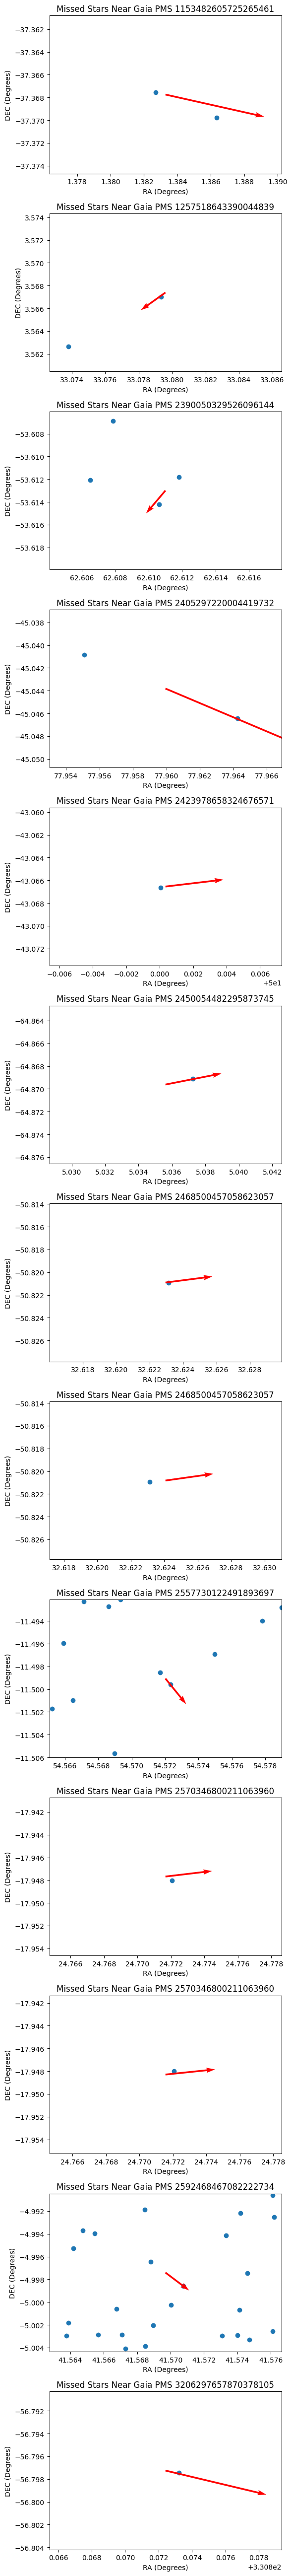

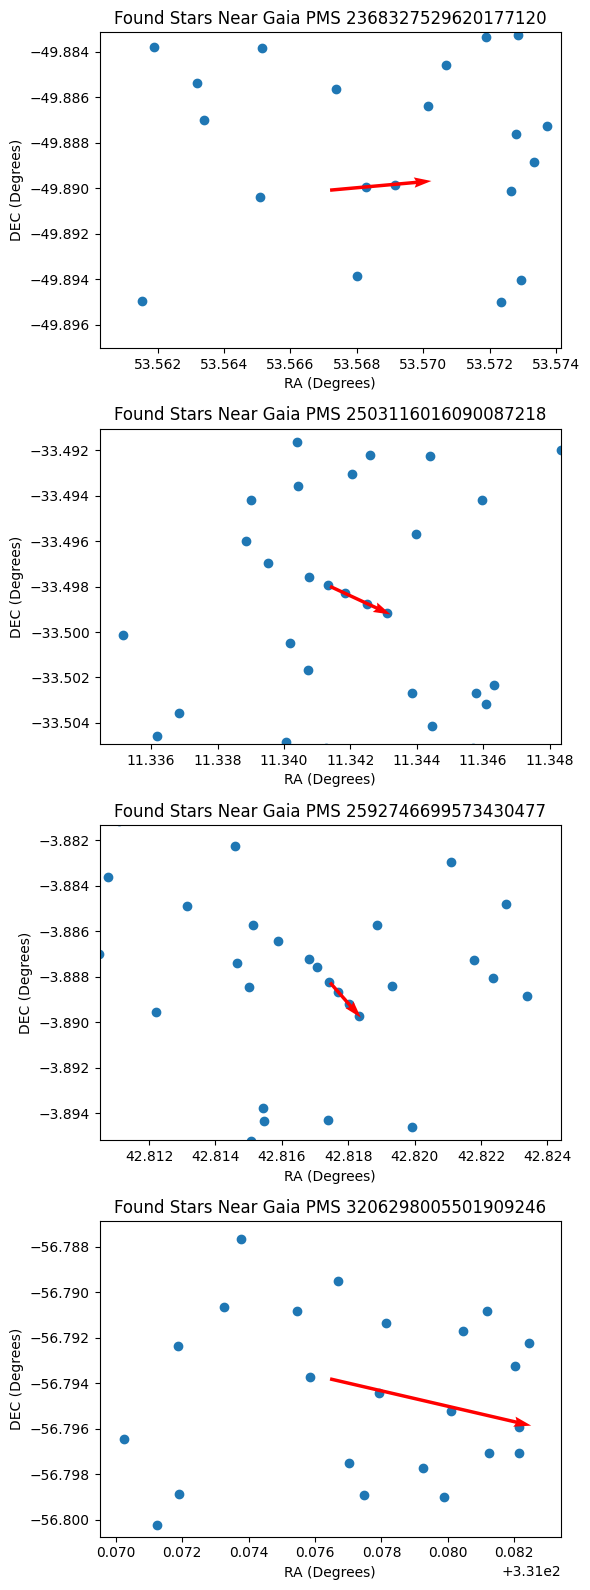

In [40]:
plot_missed_pms(df=df_no_dupes, check_column='algo_found', cone_search_rad=cone_search_rad)
plot_found_pms(df=df_no_dupes, check_column='algo_found', cone_search_rad=cone_search_rad)